## Comparing different groups of experiments - all



This notebook compares different groups of experiments, using the metrics described in each cell.

Each group takes a dictionary of `'experiment name': list[Experiment]`.
First, create each group by changing the experiment names in the lists on the next cell (lines 10 and 11), and then add each Group object to the `groups` list (last line of next cell).

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind 

from pasna_analysis import DataLoader, Experiment, ExperimentConfig, Group, utils

wt_config  = {
    '20240611_25C': ExperimentConfig(first_peak_threshold=30, to_exclude=[4,9,12,13,15,17,18,19,21,23]), 
    '20240919_25C': ExperimentConfig(first_peak_threshold=30, to_exclude=[2,5,6,7,11,14,16,18])
}

vglut_config = {
    '20240828-vglutdf': ExperimentConfig(first_peak_threshold=30, to_exclude=[3,6,9]), # EMB 3,6,9
    '20240829-vglutdf': ExperimentConfig(first_peak_threshold=30, to_exclude=[6,8]), # EMB 6,8
    '20240830-vglutdf': ExperimentConfig(first_peak_threshold=30, to_exclude=[6]) # EMB 6
}

vgat_config = {
    '20241008_vgatdf': ExperimentConfig(first_peak_threshold=30, to_exclude=[2,4]),
    '20241009_vgatdf': ExperimentConfig(first_peak_threshold=30, to_exclude=[7,18,19]),
    '20241010_vgatdf': ExperimentConfig(first_peak_threshold=30, to_exclude=[8]),
    '20241011_vgatdf': ExperimentConfig(first_peak_threshold=30, to_exclude=[2,4,11,5]),
}

wt_experiments = {}
for exp, config in wt_config.items():
    exp_path = Path.cwd().parent.joinpath('data', exp)
    wt_experiments[exp] = Experiment(DataLoader(exp_path), config.first_peak_threshold, config.to_exclude, dff_strategy='local_minima')

vglut_experiments = {}
for exp, config in vglut_config.items():
    exp_path = Path.cwd().parent.joinpath('data', exp)
    vglut_experiments[exp] = Experiment(DataLoader(exp_path), config.first_peak_threshold, config.to_exclude, dff_strategy='local_minima')

vgat_experiments = {}
for exp, config in vgat_config.items():
    exp_path = Path.cwd().parent.joinpath('data', exp)
    vgat_experiments[exp] = Experiment(DataLoader(exp_path), config.first_peak_threshold, config.to_exclude, dff_strategy='local_minima')

wt = Group('WT', wt_experiments)
vglut = Group('VGluT-', vglut_experiments)
vgat = Group('VGAT-', vgat_experiments)

groups = [wt, vglut, vgat]

20240919_25C  |  First peak detected before 30 mins for emb12 (t=2.3 mins). Skipping..
20241009_vgatdf  |  First peak detected before 30 mins for emb3 (t=12.4 mins). Skipping..


WT 8
WT 14
VGluT- 7
VGluT- 7
VGluT- 7
VGAT- 3
VGAT- 3
VGAT- 3
VGAT- 7
0     2.125108
1     2.228991
2     2.231409
3     2.153342
4     2.134851
5     2.206224
6     2.320982
7     2.233332
8     2.151579
9     2.073619
10    1.992343
11    2.008402
12    1.992772
13    2.296539
14    2.032256
15    2.127173
16    2.212033
17    1.891245
18    1.981110
19    2.171159
20    2.093813
21    2.258980
Name: dev_fp, dtype: float64
wt vs vglut TtestResult(statistic=np.float64(6.478379517199008), pvalue=np.float64(9.031510053107766e-08), df=np.float64(41.0))
wt vs vgat TtestResult(statistic=np.float64(0.11975743254739571), pvalue=np.float64(0.905341147890296), df=np.float64(36.0))


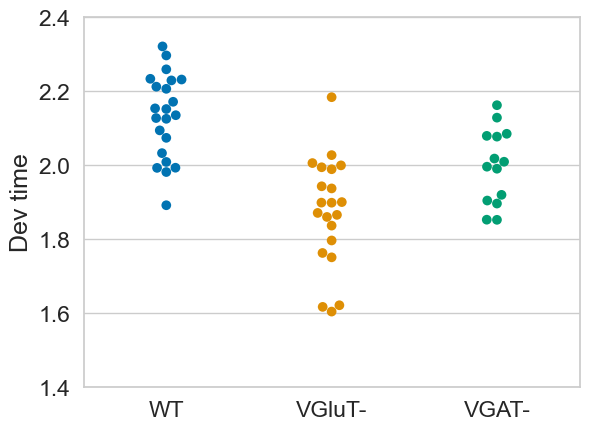

In [6]:
'''Developmental times at first peak.'''
data = {'dev_fp': [], 'group': []}

for group in groups:
    for exp in group.experiments.values():
        num = 0
        for emb in exp.embryos:
            num = num + 1
            trace = exp.traces[emb.name]
            time_first_peak = trace.peak_times[0]
            dev_time_first_peak = emb.get_DT_from_time(time_first_peak)

            data['dev_fp'].append(dev_time_first_peak)
            data['group'].append(group.name)
        print(group.name, num)
df = pd.DataFrame(data)
group_avgs = {'group': [], 'fp_avg': []}

for group in groups:
    g = df[df['group']==group.name]
    group_avgs['group'].append(group.name)
    group_avgs['fp_avg'].append(g['dev_fp'].mean())

font_scale = 1.5
sns.set_theme(style='whitegrid', palette='colorblind', font_scale=font_scale)
ax = sns.swarmplot(data=data, x='group', y='dev_fp', hue='group', size=7)
ax.set(ylim=(1.4, 2.4))
# ax.set_title('Dev time at first burst')
ax.set_ylabel('Dev time')
ax.set_xlabel('');

wt = df[df['group']=='WT']
vglut = df[df['group']=='VGluT-']
vgat = df[df['group']=='VGAT-']

print('wt vs vglut', ttest_ind(wt['dev_fp'], vglut['dev_fp']))
print('wt vs vgat', ttest_ind(wt['dev_fp'], vgat['dev_fp']))
plt.savefig('wt_vglut_vgat_onsettime.svg')



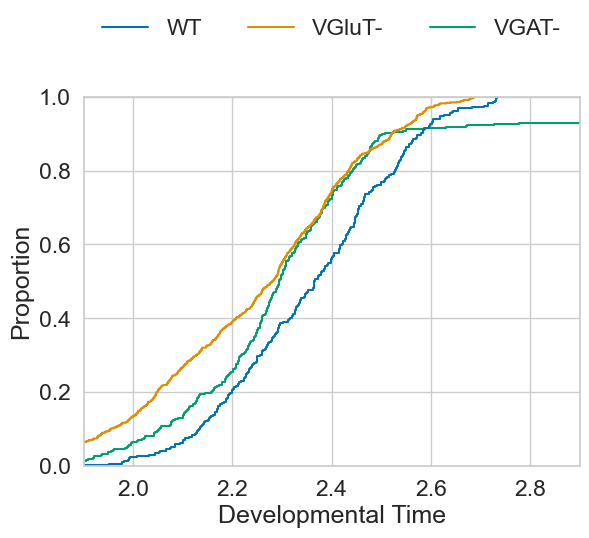

In [ ]:
'''CDF of peak developmental times'''
data = {'dev_time': [], 'group': []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos:
            trace = exp.traces[emb.name]
            dev_times = [emb.get_DT_from_time(t) for t in trace.peak_times]
            data['dev_time'].extend(dev_times)
            data['group'].extend([group.name]*len(dev_times))

font_scale = 1.5
sns.set_theme(style='whitegrid', palette='colorblind', font_scale=font_scale)
ax = sns.ecdfplot(data=data, x='dev_time', hue='group')
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1.1), ncol=3, title=None, frameon=False,)
ax.set_xlim([1.9, 2.9])
# ax.set_title('CDF developmental times of peaks')
ax.set_ylabel('Proportion')
ax.set_xlabel('Developmental Time');
plt.savefig('wt_vglut_vgat_devtimepeak.svg')

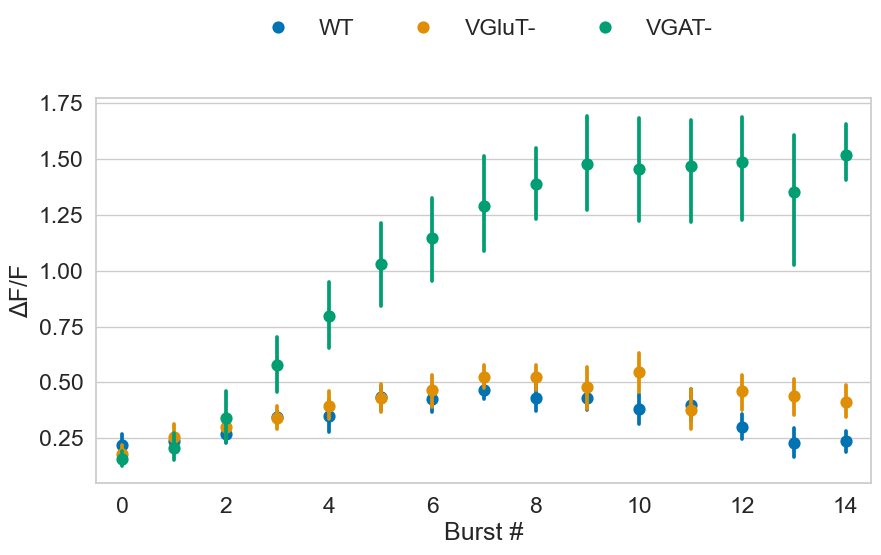

In [ ]:
'''Peak amplitudes for each episode.'''
num_of_peaks = 15
data = {'peak_amp': [], 'group': [], 'peak_idx': []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos:
            t = exp.traces[emb.name]
            for i, amp in zip(range(num_of_peaks), t.peak_amplitudes):
                data['peak_amp'].append(amp)
                data['group'].append(group.name)
                data['peak_idx'].append(i)

amps = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 5))

font_scale = 1.5
sns.set_theme(style='whitegrid', palette='colorblind', font_scale=font_scale)
ax = sns.pointplot(data=data, x='peak_idx', y='peak_amp', hue='group', linestyle='None')
ax.set_xticks([0, 2,4,6,8,10,12, 14])
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1.1), ncol=3, title=None, frameon=False,)
# ax.set_title(f'Burst amplitudes')
ax.set_xlabel('Burst #')
ax.set_ylabel('\u0394F/F');
plt.savefig('wt_vglut_vgat_amps.svg')

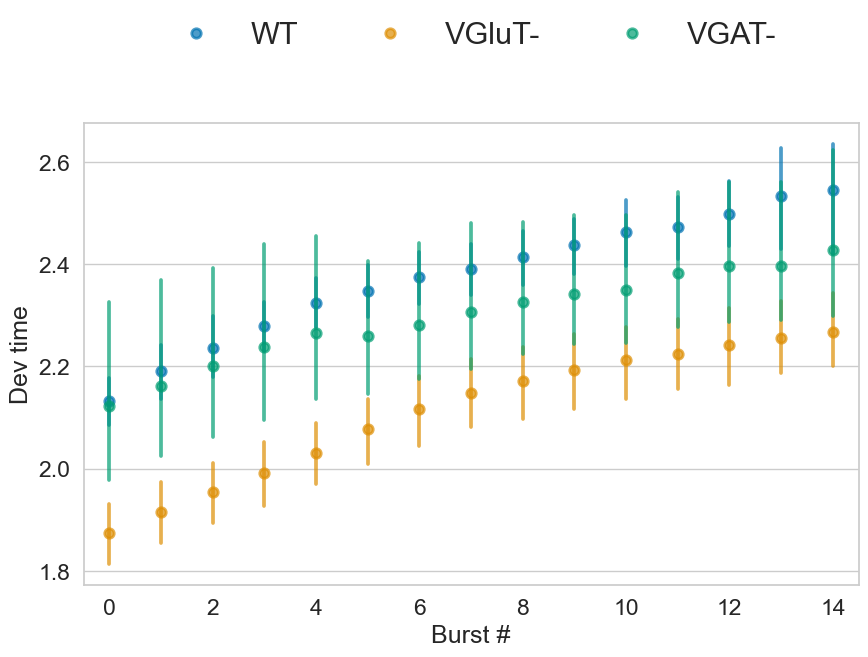

In [ ]:
'''Developmental time for each episode.'''
data = {'group': [], 'dev_time': [], 'idx': []}

for group in groups:
    for exp in group.experiments.values():
        for emb_n, emb in enumerate(exp.embryos):
            trace = exp.traces[emb.name]
            for i, t in zip(range(15), trace.peak_times):
                data['group'].append(group.name)
                data['dev_time'].append(emb.get_DT_from_time(t))
                data['idx'].append(i)

dev_times = pd.DataFrame(data)


f, ax = plt.subplots(figsize=(10,6))
font_scale = 2
sns.set_theme(style='whitegrid', palette='colorblind', font_scale=font_scale)
ax = sns.pointplot(data=dev_times, x='idx', y='dev_time', hue='group', alpha=0.7, errorbar='ci', linestyle='None')
ax.set_xticks([0, 2,4,6,8,10,12, 14])
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1.1), ncol=3, title=None, frameon=False,)
# ax.set_title('Dev time per burst')
ax.set_xlabel('Burst #')
ax.set_ylabel('Dev time');
plt.savefig('wt_vglut_vgat_devtimepeak.svg')

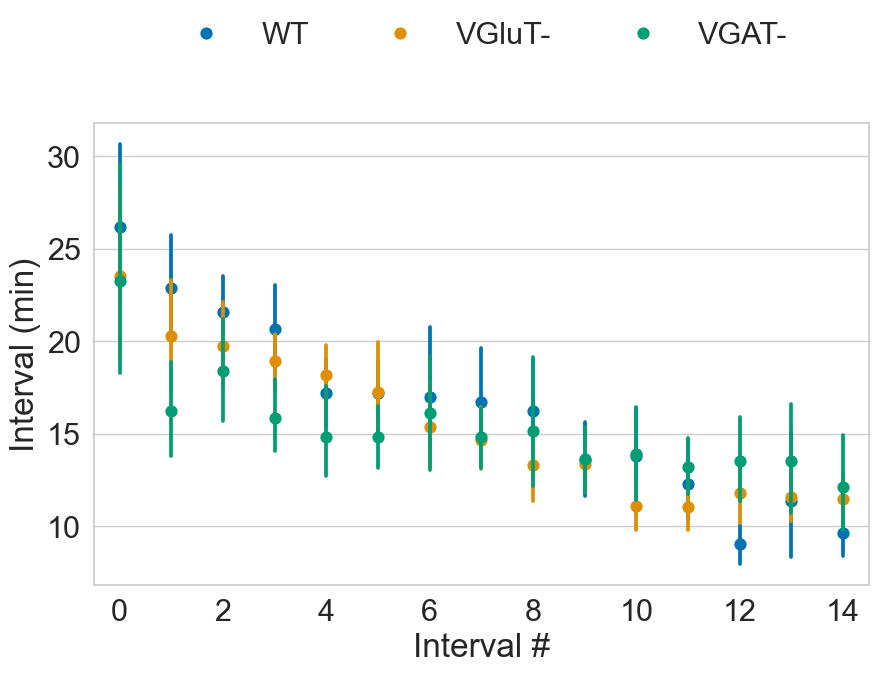

In [ ]:
'''Intervals between each episode.'''
data = {'group': [], 'interval': [], 'idx': []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos:
            trace = exp.traces[emb.name]
            for i, interval in zip(range(15), trace.peak_intervals):
                data['group'].append(group.name)
                data['interval'].append(interval/60)
                data['idx'].append(i)

amps = pd.DataFrame(data)

f, ax = plt.subplots(figsize=(10,6))
font_scale = 2
sns.set_theme(style='whitegrid', palette='colorblind', font_scale=font_scale)
ax = sns.pointplot(data=amps, x='idx', y='interval', hue='group', linestyle='None')
ax.set_xticks([0, 2,4,6,8,10,12, 14])
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1.1), ncol=3, title=None, frameon=False,)
# ax.set_title('Intervals by burst')
ax.set_xlabel('Interval #')
ax.set_ylabel('Interval (min)');
plt.savefig('wt_vglut_vgat_interval.svg')

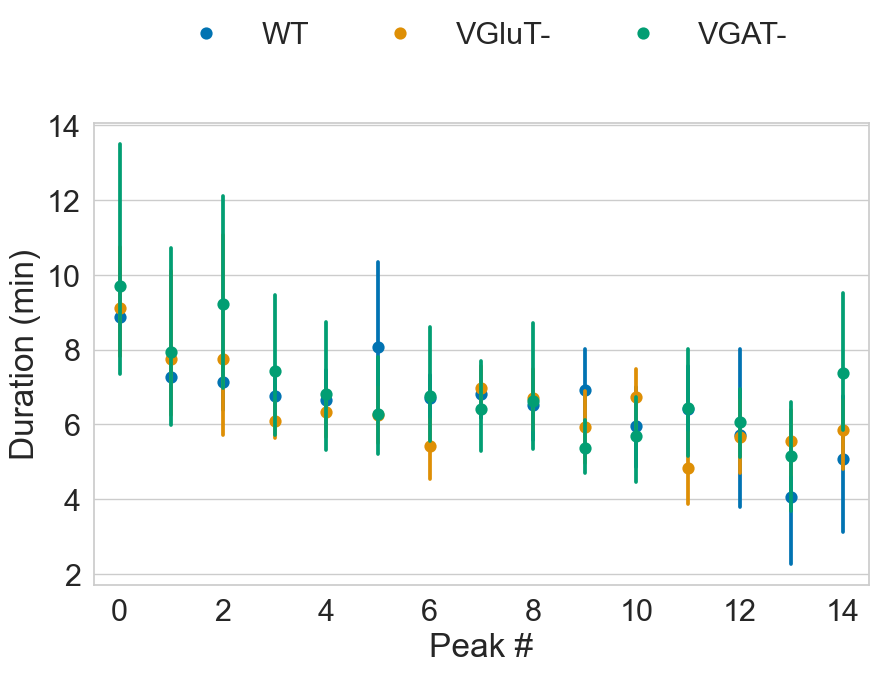

In [ ]:
'''Duration of each peak.'''
data = {'group': [], 'duration': [], 'idx': []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos:
            trace = exp.traces[emb.name]
            for i, duration in zip(range(15), trace.peak_durations):
                data['group'].append(group.name)
                data['duration'].append(duration/60)
                data['idx'].append(i)

amps = pd.DataFrame(data)

f, ax = plt.subplots(figsize=(10,6))
font_scale = 2
sns.set_theme(style='whitegrid', palette='colorblind', font_scale=font_scale)
ax = sns.pointplot(data=amps, x='idx', y='duration', hue='group', linestyle ='None')
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1.1), ncol=3, title=None, frameon=False)
ax.set_xticks([0, 2,4,6,8,10,12, 14])
# ax.set_title('Durations by peak')
ax.set_xlabel('Peak #')
ax.set_ylabel('Duration (min)');
plt.savefig('wt_vglut_vgat_durations.svg')

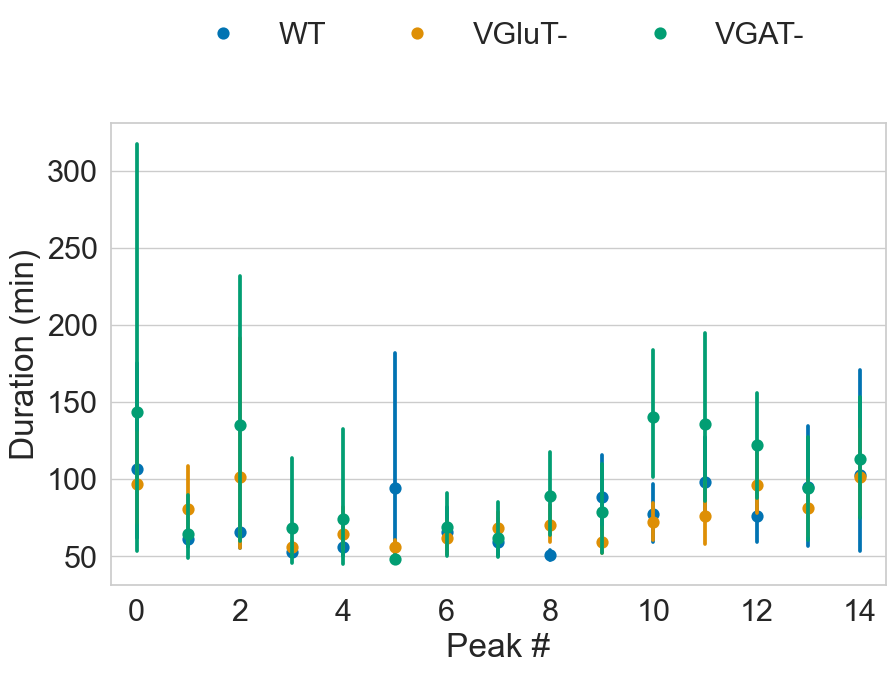

In [ ]:
'''Rise times'''
data = {'group': [], 'rise_times': [], 'idx': []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos:
            trace = exp.traces[emb.name]
            for i, rise in zip(range(15), trace.peak_rise_times):
                data['group'].append(group.name)
                data['rise_times'].append(rise)
                data['idx'].append(i)

amps = pd.DataFrame(data)

f, ax = plt.subplots(figsize=(10,6))
font_scale = 2
sns.set_theme(style='whitegrid', palette='colorblind', font_scale=font_scale)
ax = sns.pointplot(data=amps, x='idx', y='rise_times', hue='group',linestyle ='None')
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1.1), ncol=3, title=None, frameon=False,)
ax.set_xticks([0, 2,4,6,8,10,12, 14])
# ax.set_title('Peak rise times')
ax.set_xlabel('Peak #')
ax.set_ylabel('Duration (min)');
plt.savefig('wt_vglut_vgat_risetime.svg')

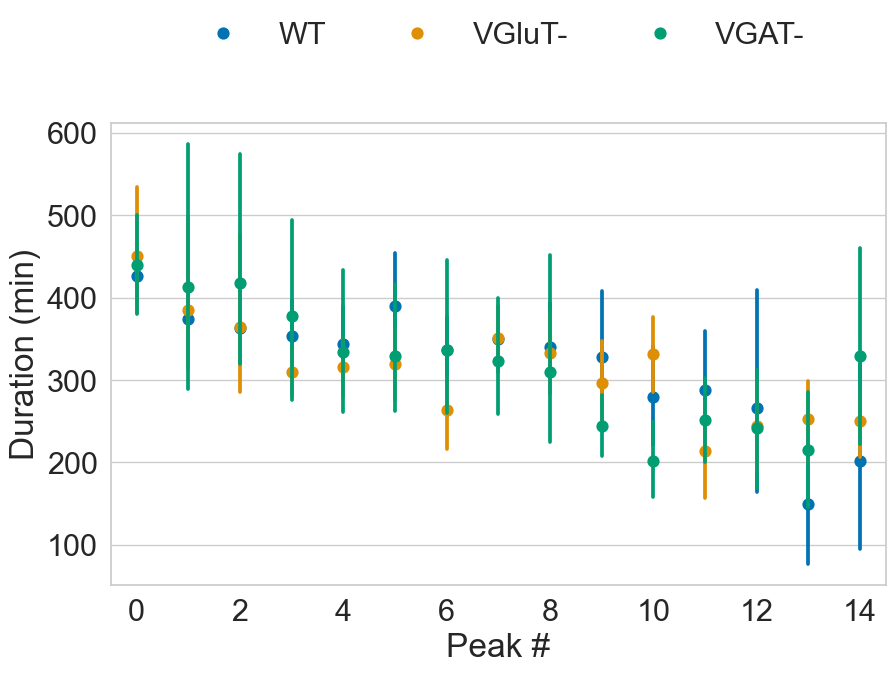

In [ ]:
'''Decay times'''
data = {'group': [], 'decay_times': [], 'idx': []}

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos:
            trace = exp.traces[emb.name]
            for i, decay in zip(range(15), trace.peak_decay_times):
                data['group'].append(group.name)
                data['decay_times'].append(decay)
                data['idx'].append(i)

amps = pd.DataFrame(data)

f, ax = plt.subplots(figsize=(10,6))
font_scale = 2
sns.set_theme(style='whitegrid', palette='colorblind', font_scale=font_scale)
ax = sns.pointplot(data=amps, x='idx', y='decay_times', hue='group', errorbar='ci', linestyle='None')
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1.1), ncol=3, title=None, frameon=False,)
ax.set_xticks([0, 2,4,6,8,10,12, 14])
# ax.set_title('Peak decay times')
ax.set_xlabel('Peak #')
ax.set_ylabel('Duration (min)');
plt.savefig('wt_vglut_vgat_decaytime.svg')

In [ ]:
'''Developmental times at first peak.'''
data = {'dev_fp': [], 'group': []}

for group in groups:
    for exp in group.experiments.values():
        num = 0
        for emb in exp.embryos:
            num = num + 1
            trace = exp.traces[emb.name]
            time_first_peak = trace.peak_times[0]
            dev_time_first_peak = emb.get_DT_from_time(time_first_peak)

            data['dev_fp'].append(dev_time_first_peak)
            data['group'].append(group.name)
        print(group.name, num)
df = pd.DataFrame(data)

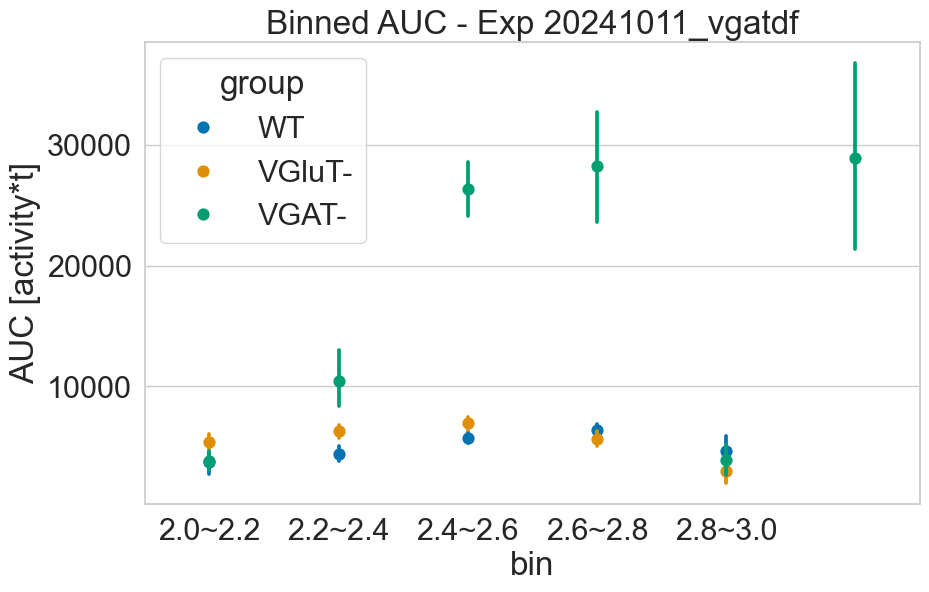

In [139]:
'''Plots AUC, grouped by bins.'''
data = {'group': [], 'auc': [], 'bin': []}

n_bins = 5
first_bin = 2
bin_width = 0.2

for group in groups:
    for exp in group.experiments.values():
        for emb in exp.embryos:
            trace = exp.traces[emb.name]
            dev_time_at_peaks = emb.get_DT_from_time(trace.peak_times)
            bins = [first_bin + j*bin_width for j in range(n_bins)]
            bin_idxs = utils.split_in_bins(dev_time_at_peaks, bins)
            data['group'].extend([str(group.name)]*len(trace.peak_aucs))
            data['auc'].extend(trace.peak_aucs)
            data['bin'].extend(bin_idxs)

# print(len(data['group']), len(data['auc']), len(data['bin']))

auc = pd.DataFrame(data)

# add a last bin point to generate the labels
bins.append(first_bin + bin_width*n_bins)

f, ax = plt.subplots(figsize=(10,6))
x_labels = [f"{s}~{e}" for (s, e) in zip(bins[:-1], bins[1:])]
ax = sns.pointplot(data=data, x='bin', y='auc', hue='group', linestyle='None')
ax.set_xticks(ticks=list(range(n_bins)), labels=x_labels)
ax.set_title(f'Binned AUC - Exp {exp.name}')
ax.set_ylabel('AUC [activity*t]');